In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

from tqdm import tqdm
import haversine as hs
import networkx as nx

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

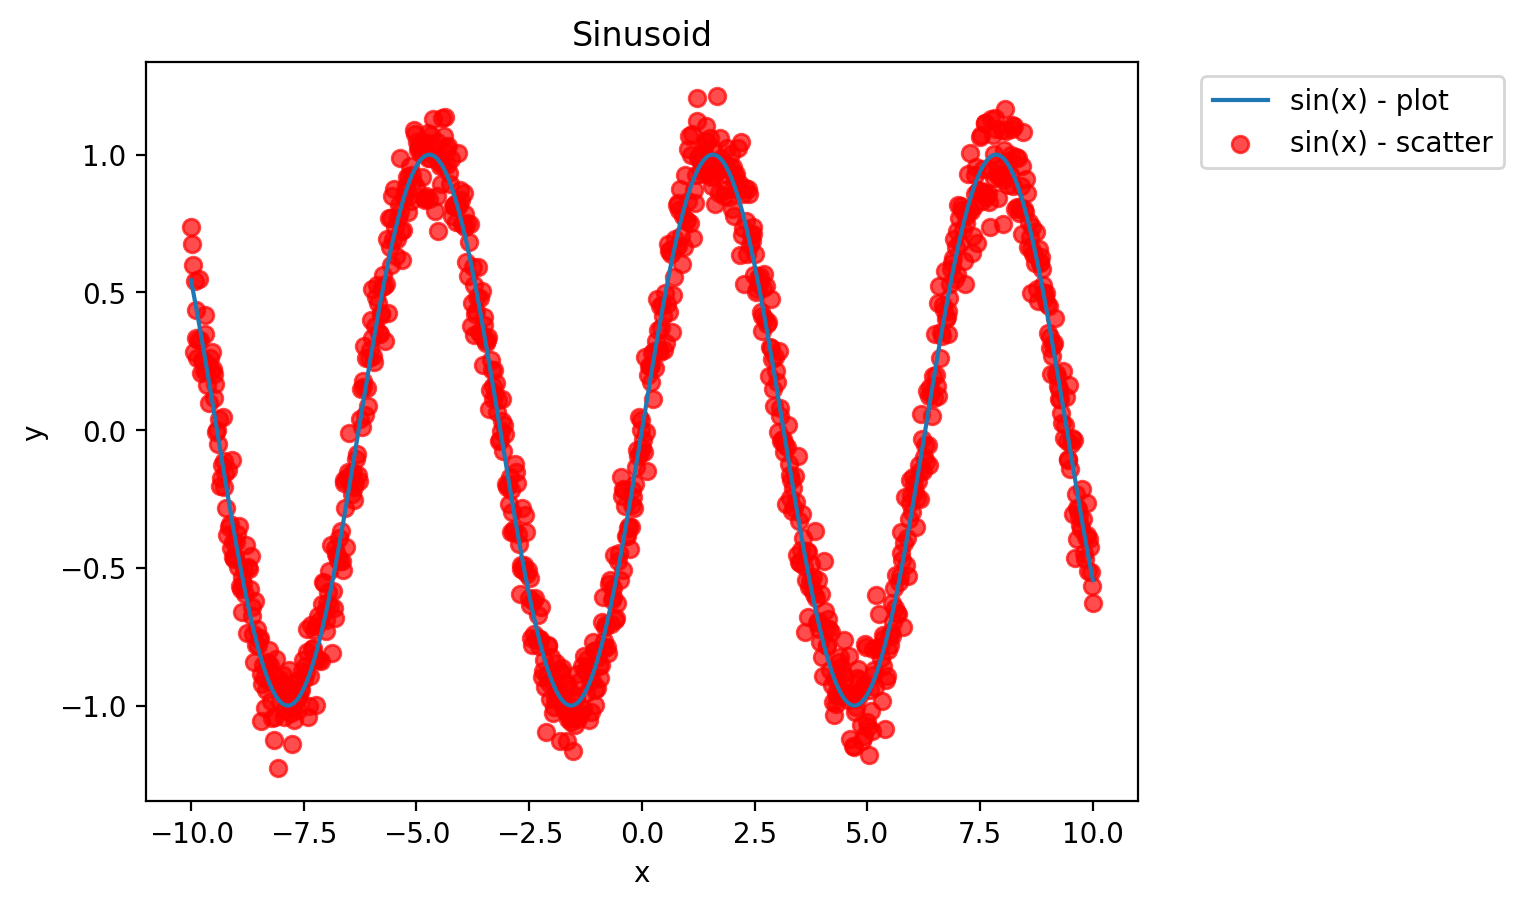

In [2]:
n_points = 1000

x = torch.linspace(-10, 10, n_points)


y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, torch.sin(x) );
plt.scatter(x, y, c = 'red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [3]:
x = StandardScaler().fit_transform(x.reshape(-1, 1))
y = StandardScaler().fit_transform(y.reshape(-1, 1))
x = torch.tensor(x, dtype=torch.float32).squeeze()
y = torch.tensor(y, dtype=torch.float32).squeeze()

In [4]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4)

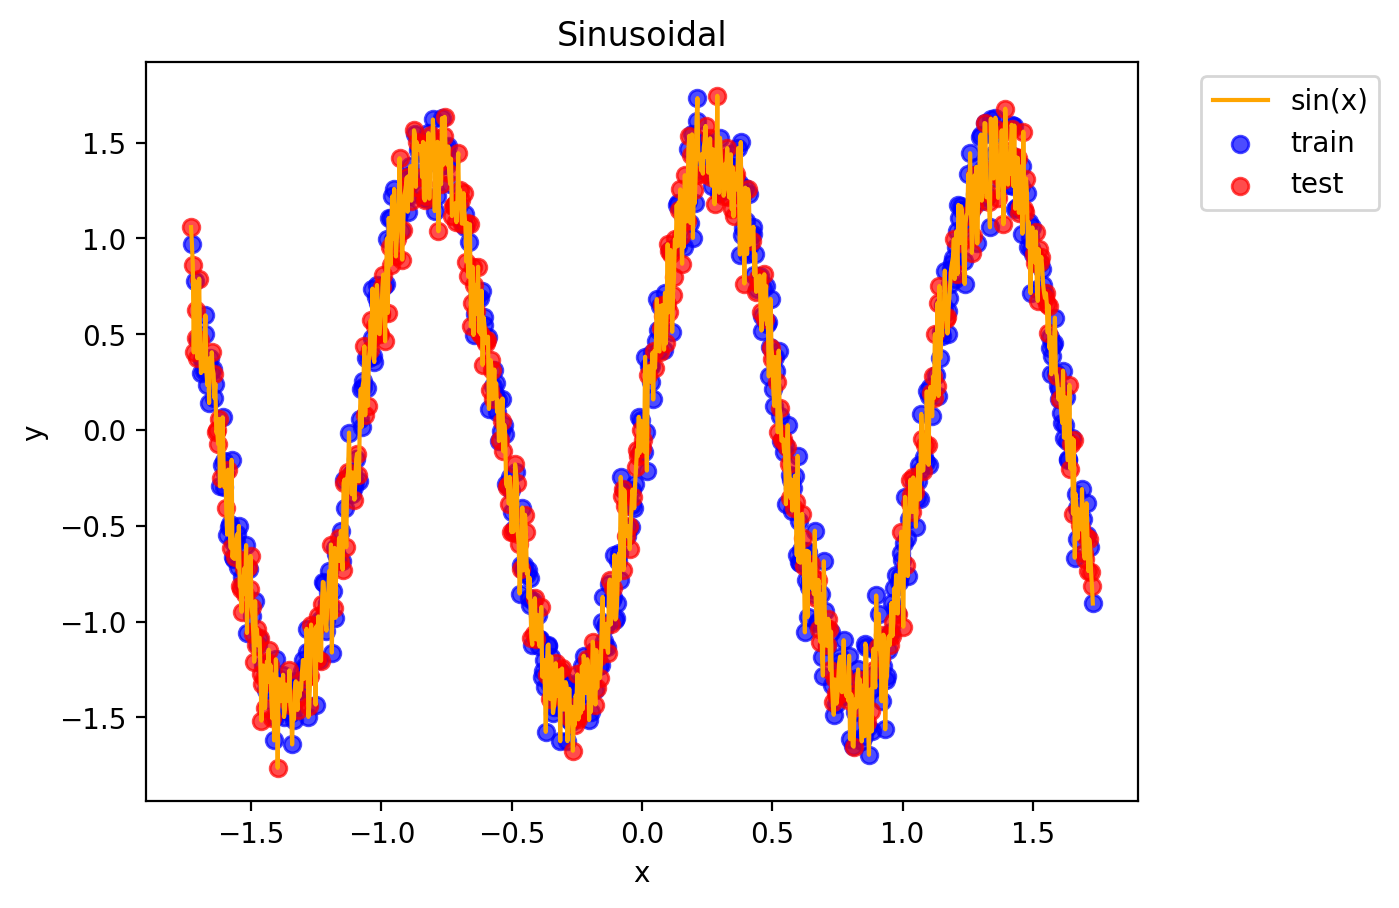

In [5]:
plt.plot(x, y, color = 'orange');
plt.scatter(train_x, train_y, c = 'blue', alpha = 0.7);
plt.scatter(test_x, test_y, c='red', alpha = 0.7);
plt.title('Sinusoidal');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [6]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear1 = nn.Linear(16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [7]:
def graph_and_data(k, x, y):
    edge_index = []
    for i in range(len(x)):
                for j in range(i+1, i+k):
                    if j >= len(x):
                        break
                    edge_index.append([i, j])
    edge_index = torch.tensor(edge_index).t().contiguous()
    train_mask = torch.zeros(y.size(0), dtype=torch.bool)
    test_mask = torch.zeros(y.size(0), dtype=torch.bool)

    for i in range(len(x)):
        if x[i] in train_x:
            train_mask[i] = True
        else:
            test_mask[i] = True

    data = Data(x=x.unsqueeze(1), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask).to(device)
    return data


In [8]:
def model_train(k, data):
    model = RegressionModel(input_dim=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_rmse_list = []
    test_rmse_list = []

    for epoch in tqdm(range(2500)):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
        loss.backward()
        optimizer.step()
        if(epoch%20==0):
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)  # Predicted PM values
                train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
                test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
                train_rmse_list.append(train_rmse.item())
                test_rmse_list.append(test_rmse.item())
            model.train()

    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
        test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
        print("Train RMSE", train_rmse.cpu().numpy())
        print("Test RMSE", test_rmse.cpu().numpy())        

    plt.plot(range(0, 20*len(train_rmse_list), 20), train_rmse_list, label='Train Loss')
    plt.plot(range(0, 20*len(test_rmse_list), 20), test_rmse_list, label='Test Loss')
    plt.xlabel('RMSE')
    plt.ylabel('Epoch')
    plt.title(f"RMSE vs Epoch - Nearest Neighbours - {k}" )
    plt.legend()
    plt.show()
    return model
    

In [9]:
def results_show(model,data):
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_preds = out[data.train_mask].cpu().squeeze().detach().numpy()
    test_preds = out[data.test_mask].cpu().squeeze().detach().numpy()

    plt.plot(data.x[data.train_mask].cpu(), train_preds, color = 'blue', label = 'train pred', alpha = 0.7)
    plt.plot(data.x[data.test_mask].cpu(), test_preds, color = 'red', label = 'test pred', alpha = 0.7)
    plt.scatter(train_x, train_y, label = 'train points', color = 'black', )
    plt.scatter(test_x, test_y, label = 'test points', color = 'grey', )
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Predicted vs Actual -  Nearest Neighbours - {k}")
    plt.show()

Data(x=[1000, 1], edge_index=[2, 999], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:19<00:00, 126.89it/s]


Train RMSE 0.1432454
Test RMSE 0.14898391


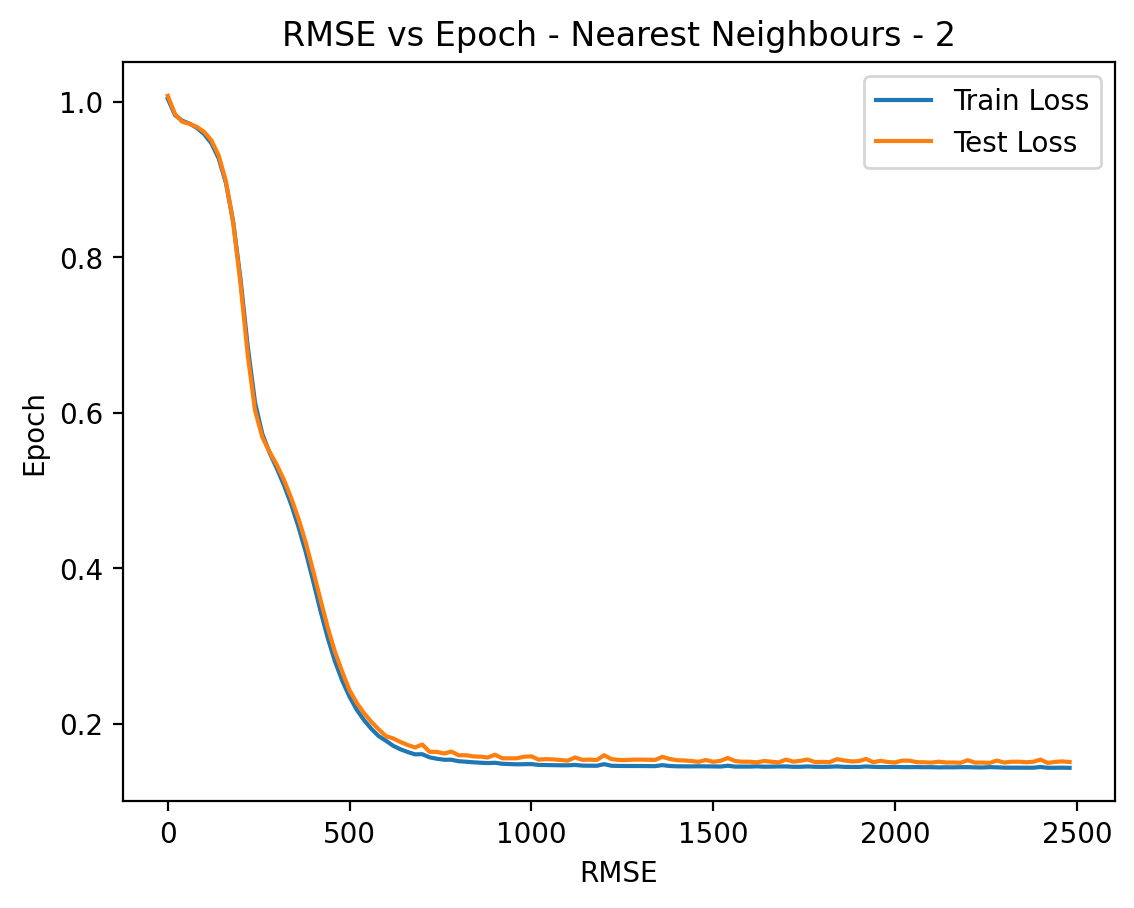

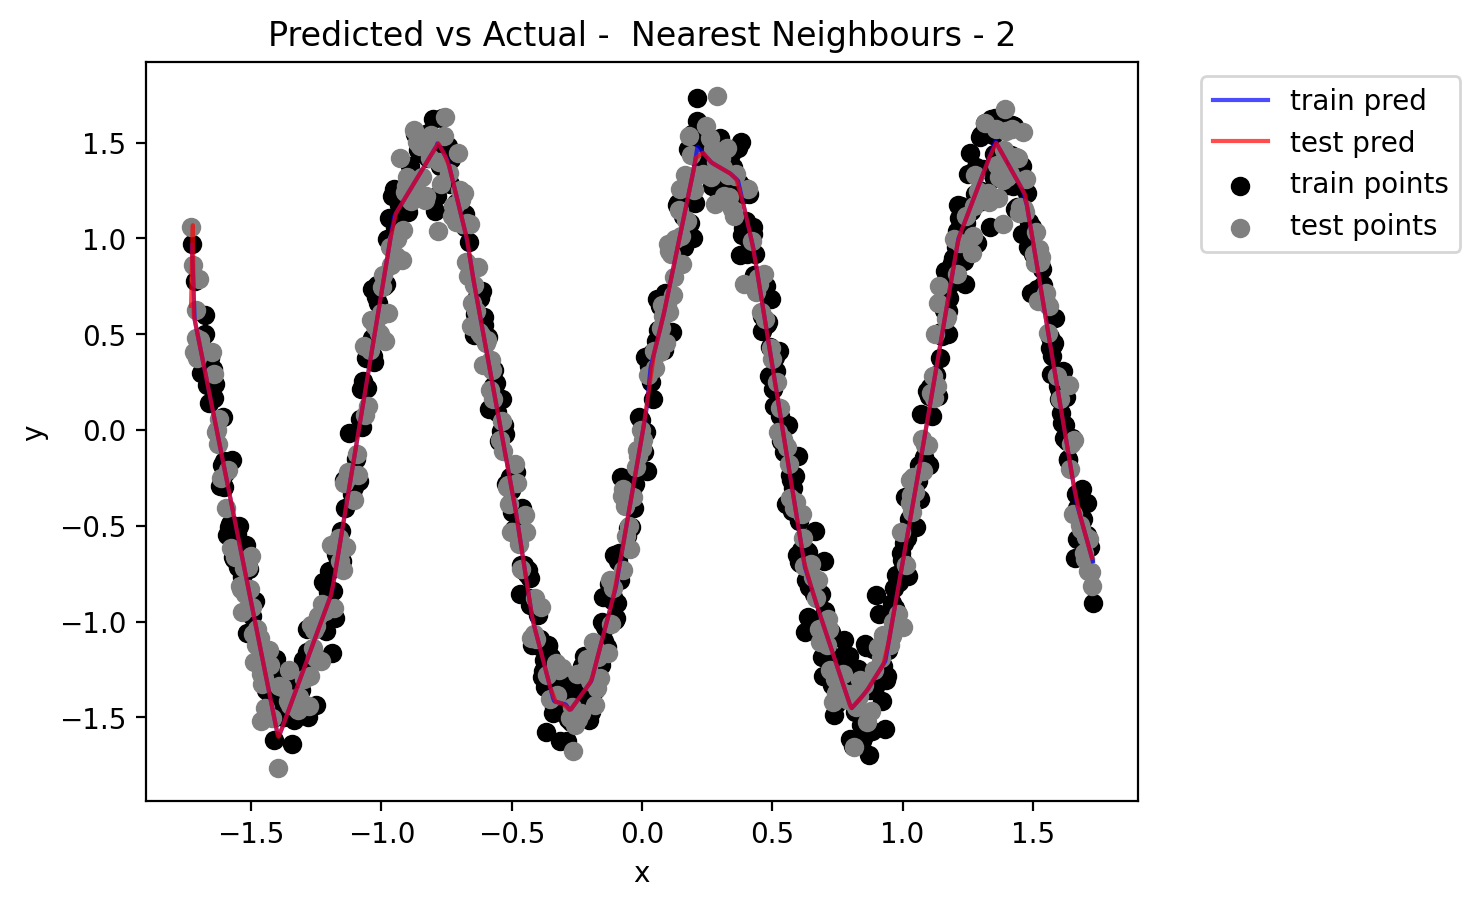

Data(x=[1000, 1], edge_index=[2, 1997], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:11<00:00, 213.96it/s]


Train RMSE 0.14064708
Test RMSE 0.15567692


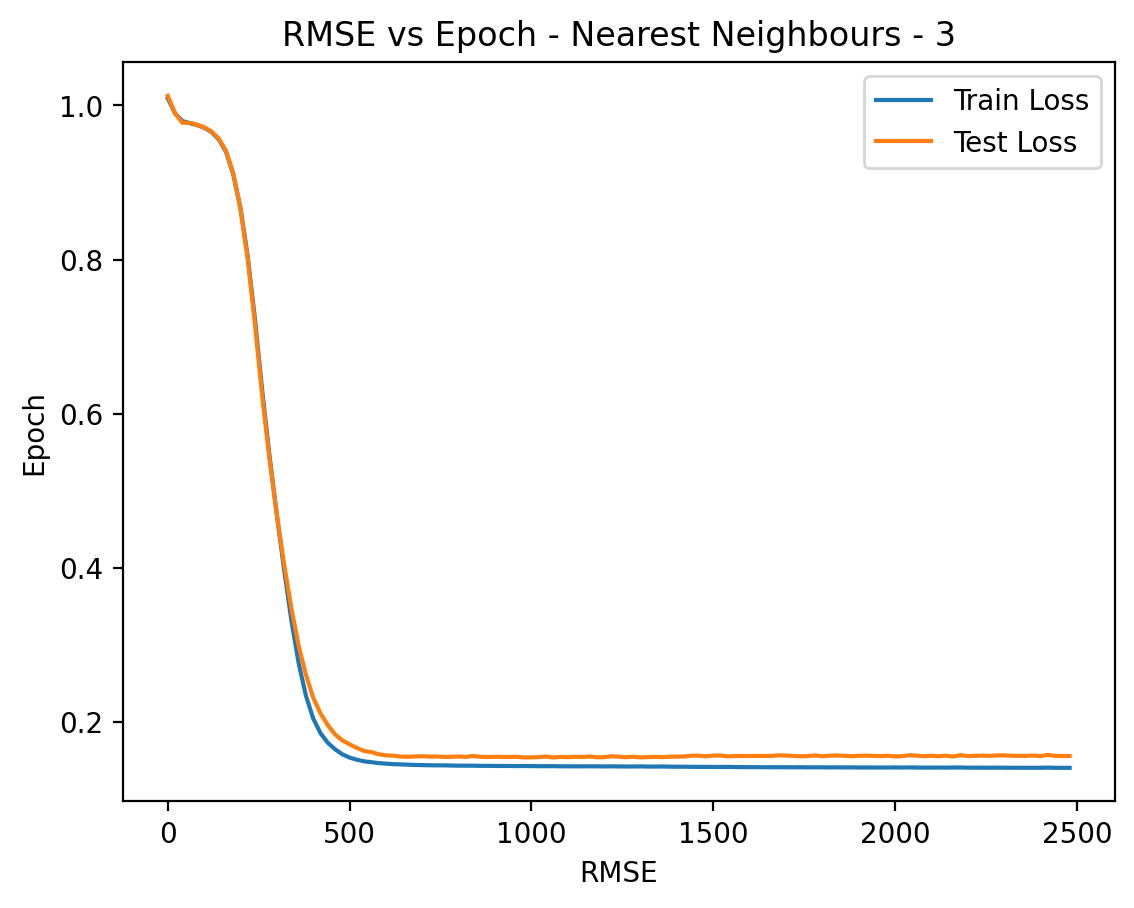

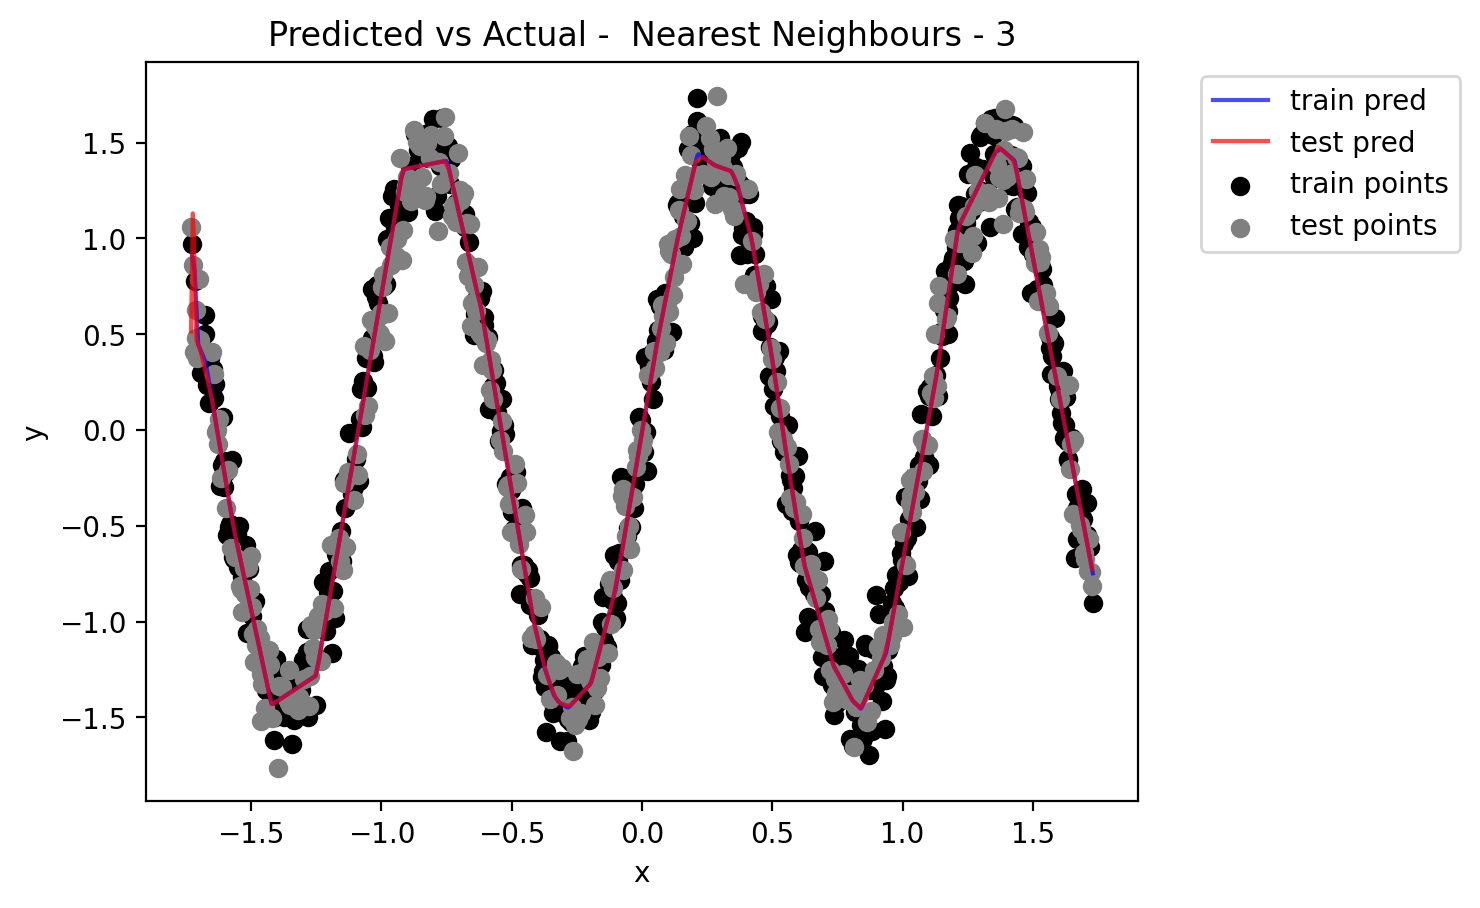

Data(x=[1000, 1], edge_index=[2, 2994], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:11<00:00, 223.39it/s]


Train RMSE 0.14461552
Test RMSE 0.1576645


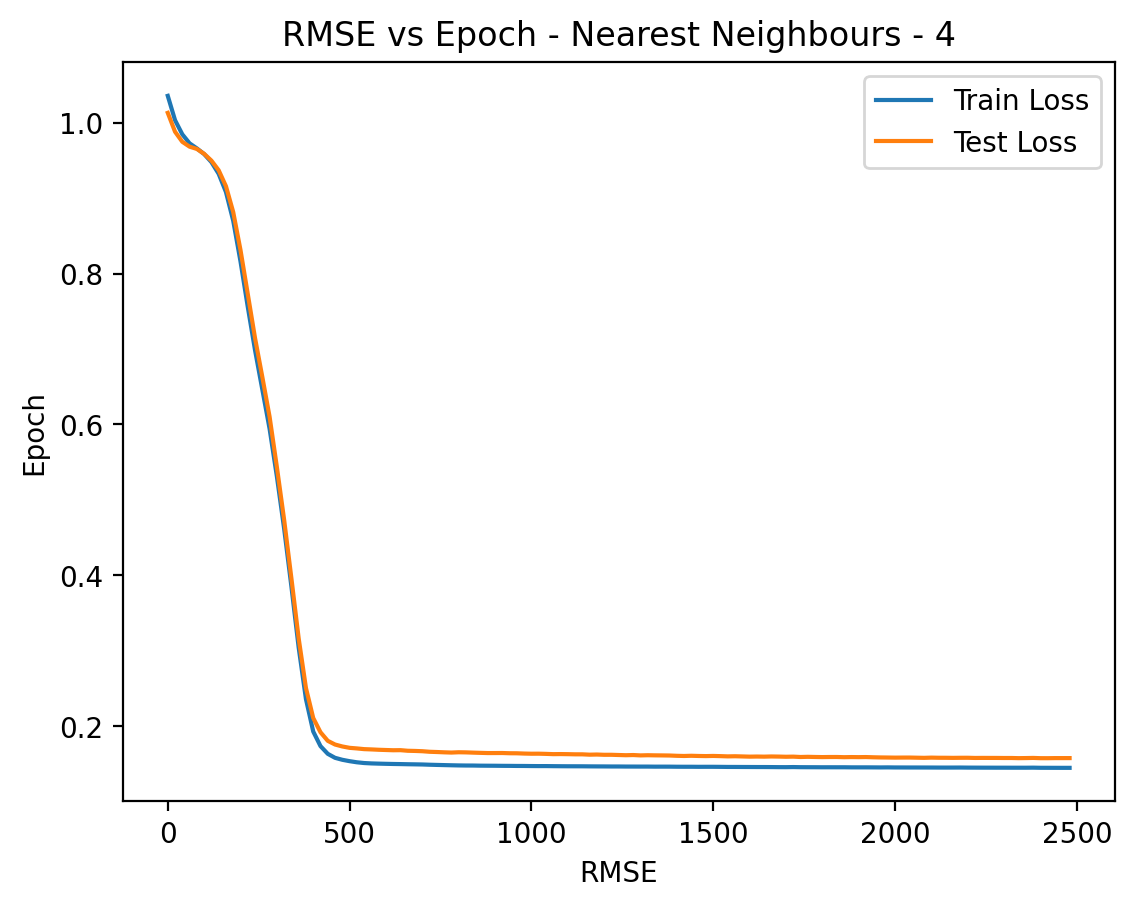

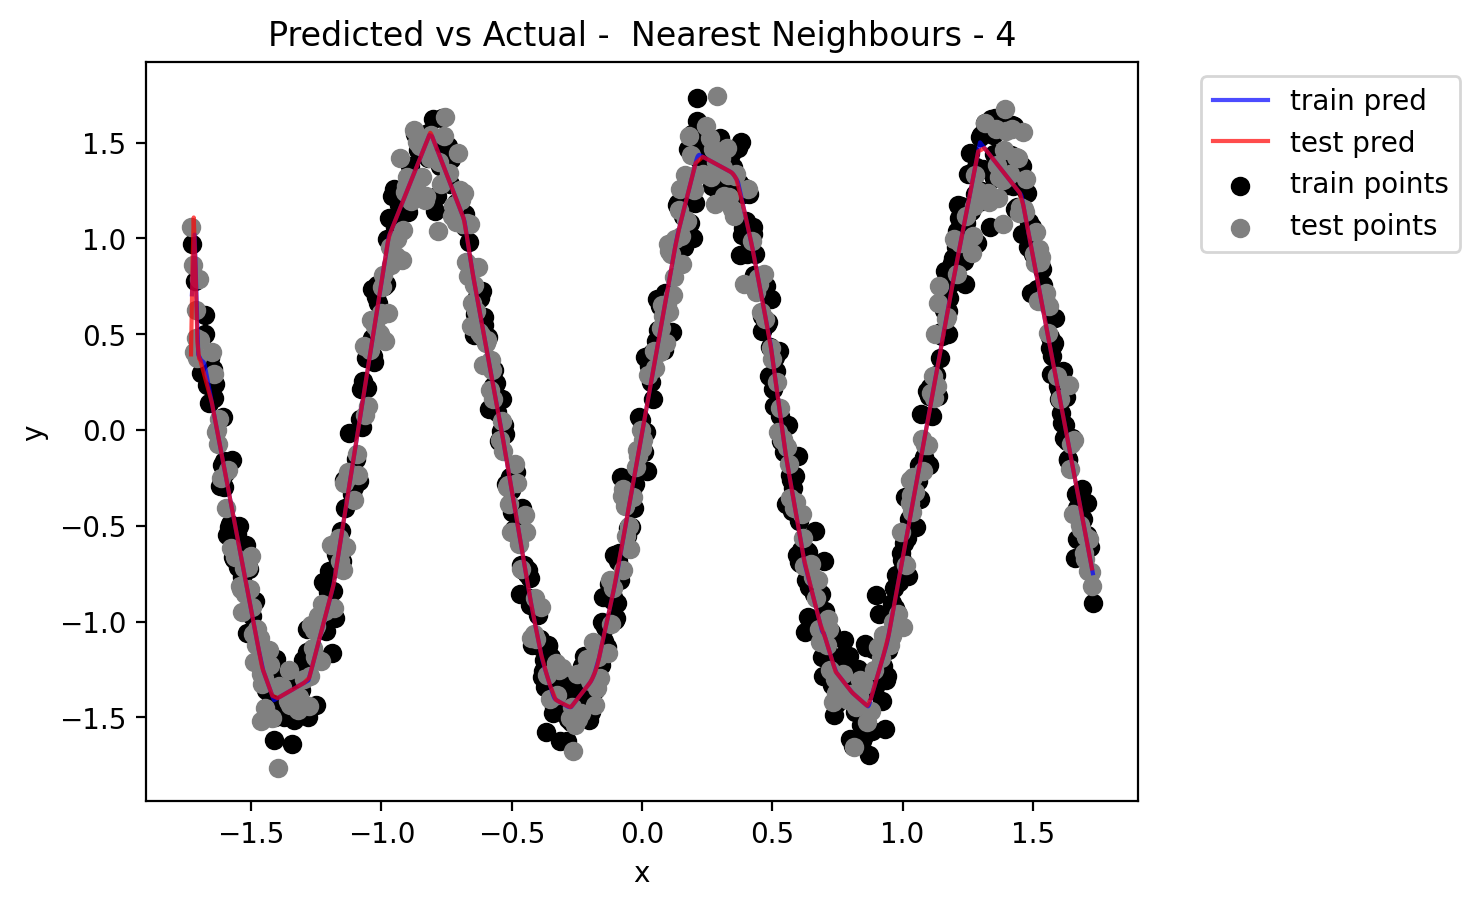

Data(x=[1000, 1], edge_index=[2, 3990], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:10<00:00, 227.73it/s]


Train RMSE 0.14280014
Test RMSE 0.1551475


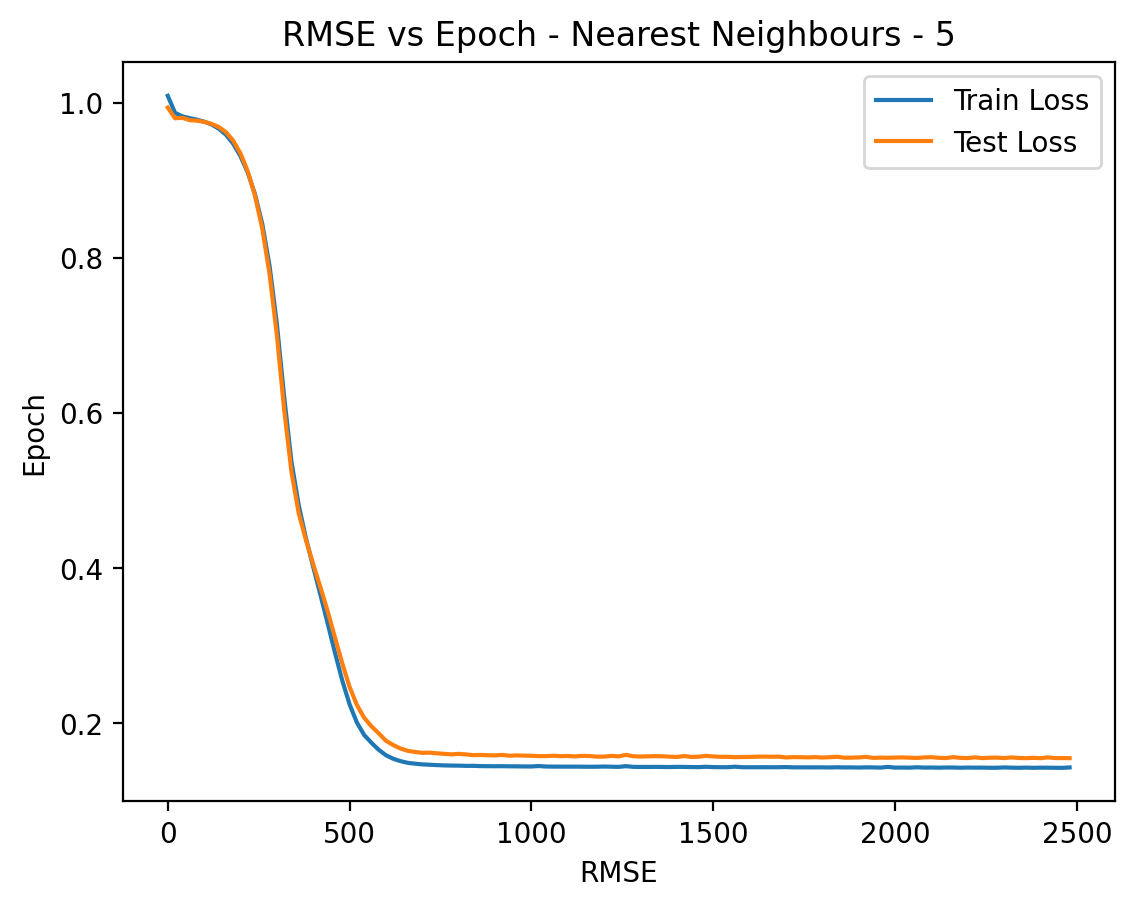

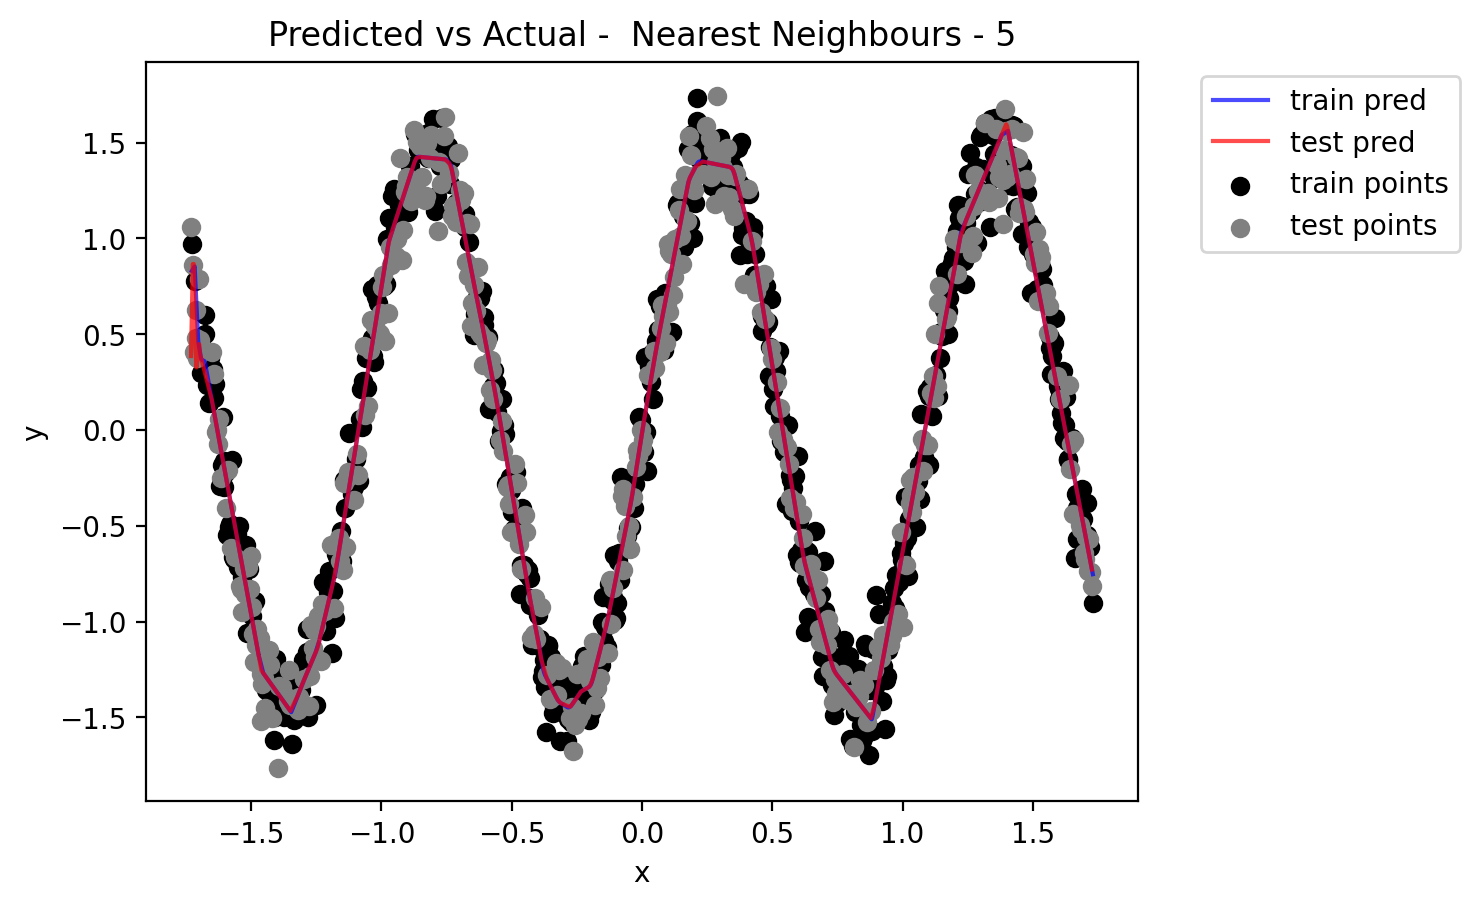

Data(x=[1000, 1], edge_index=[2, 4985], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:11<00:00, 226.62it/s]


Train RMSE 0.14328918
Test RMSE 0.15867557


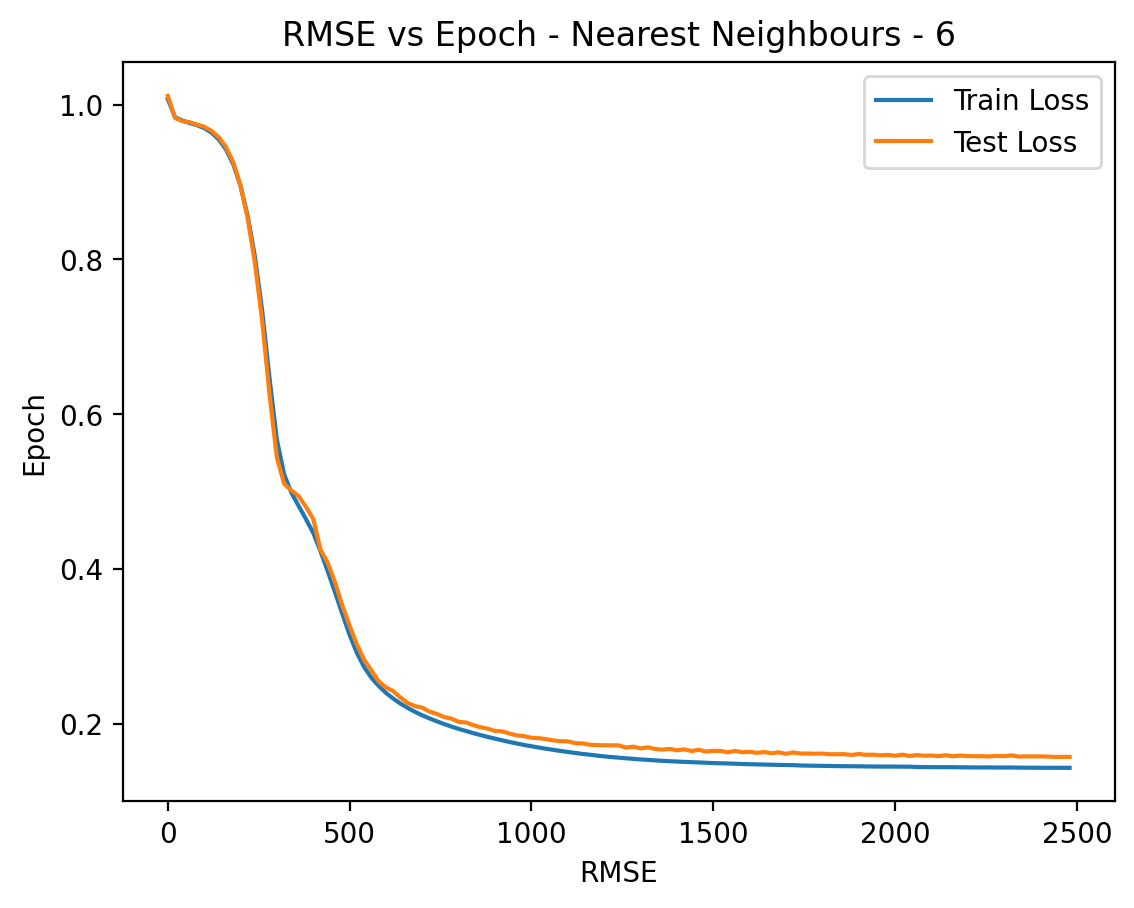

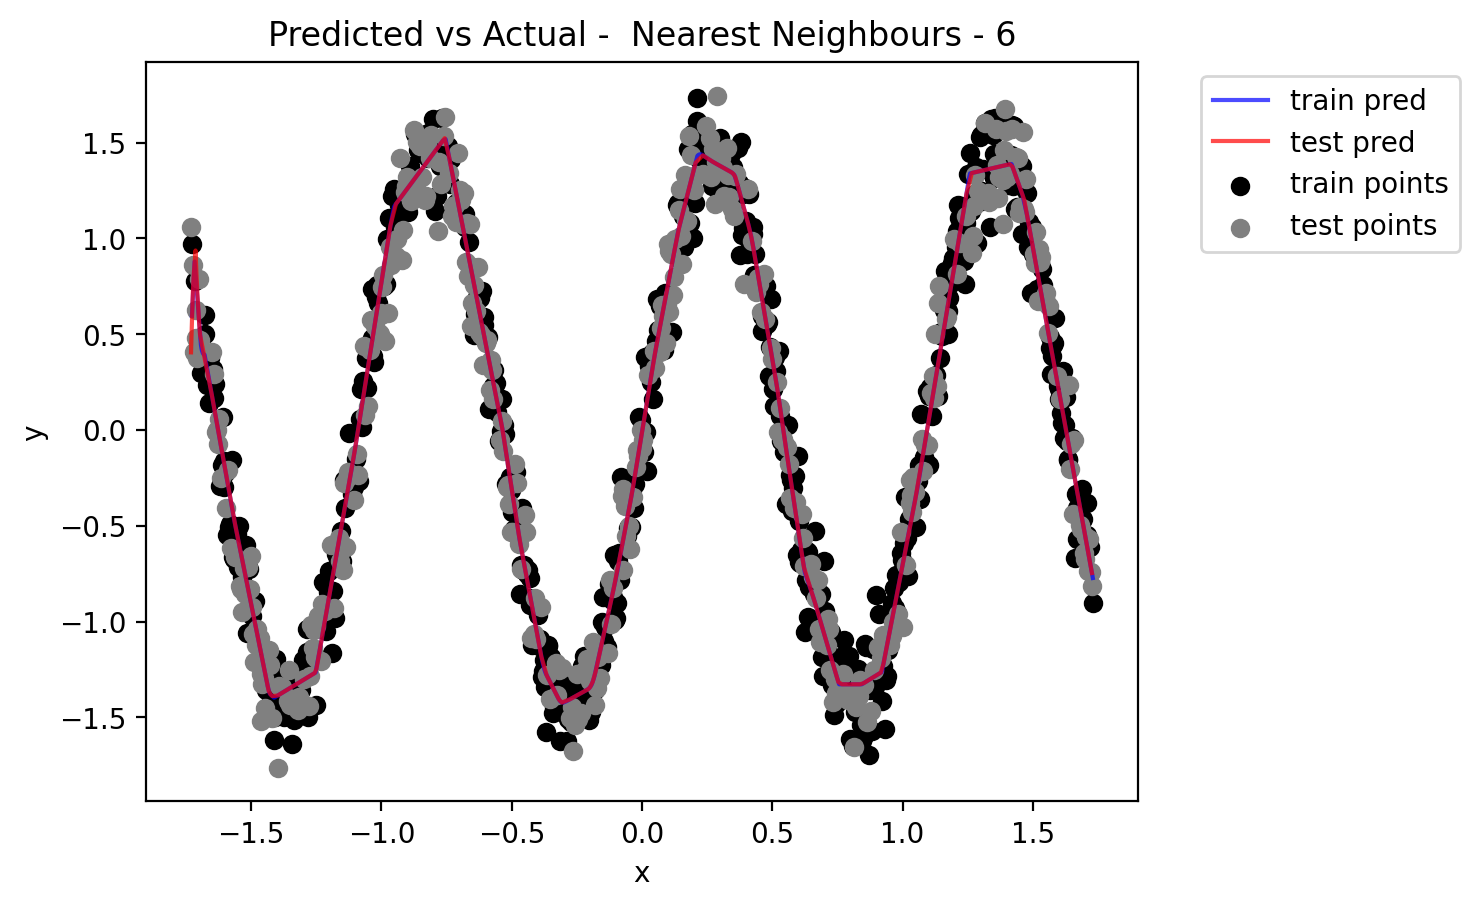

Data(x=[1000, 1], edge_index=[2, 5979], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:11<00:00, 225.53it/s]


Train RMSE 0.14266881
Test RMSE 0.15611602


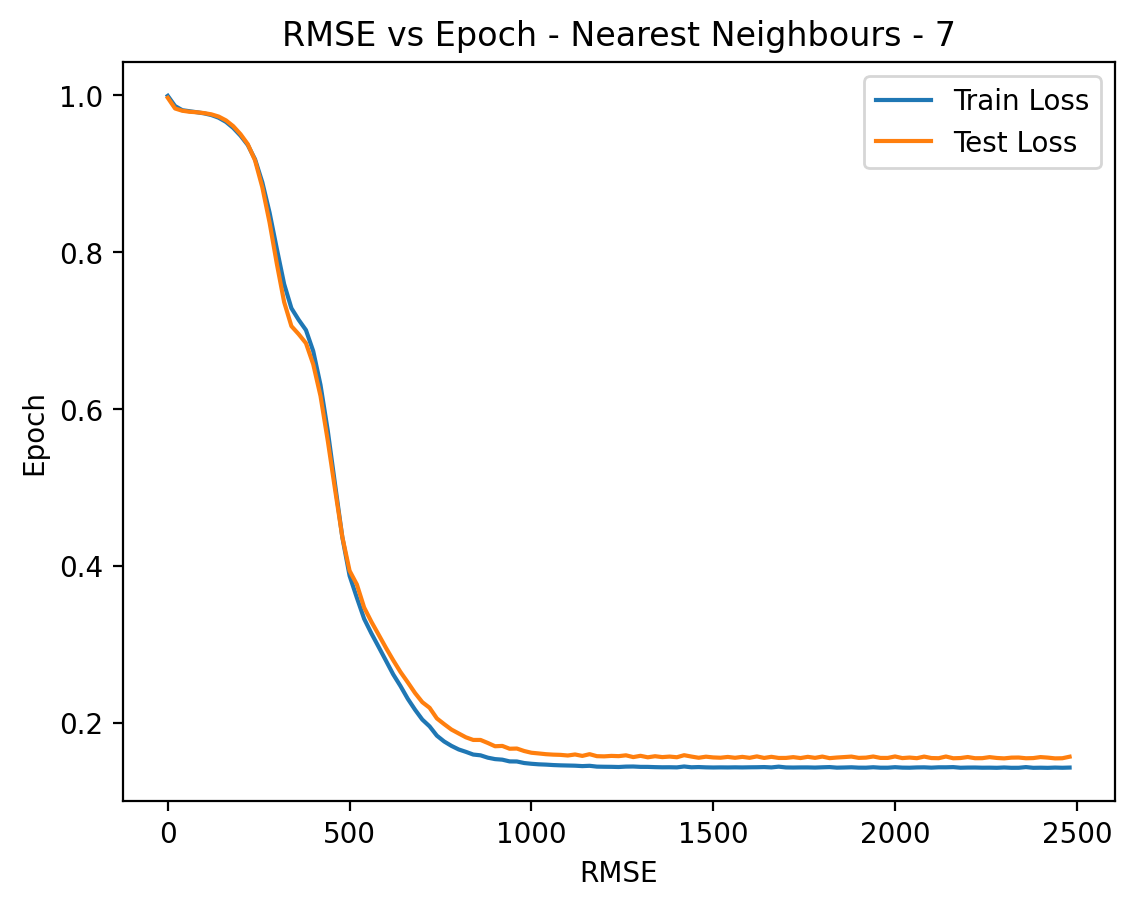

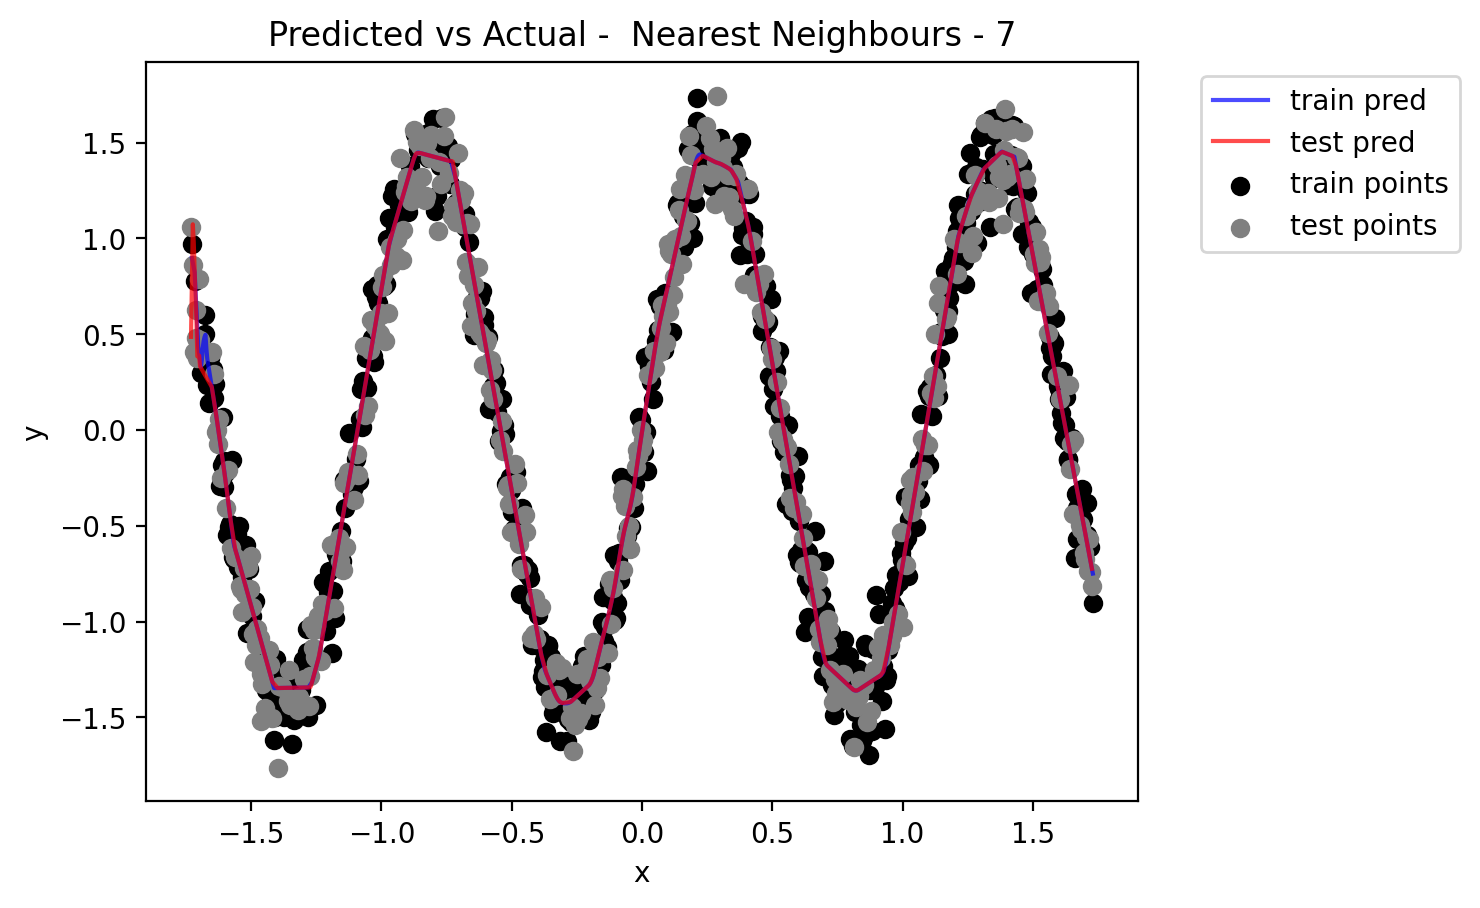

Data(x=[1000, 1], edge_index=[2, 6972], y=[1000], train_mask=[1000], test_mask=[1000])


100%|██████████| 2500/2500 [00:11<00:00, 225.42it/s]


Train RMSE 0.1424309
Test RMSE 0.15500389


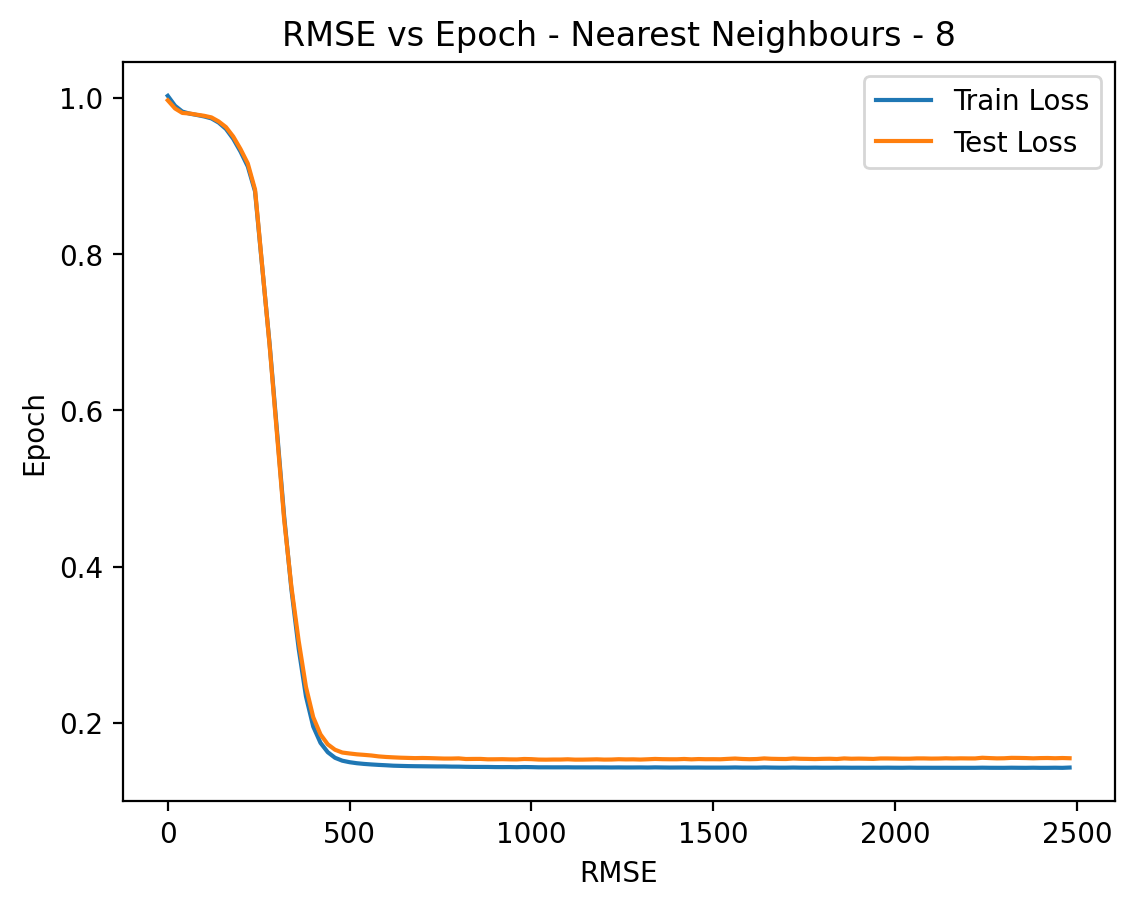

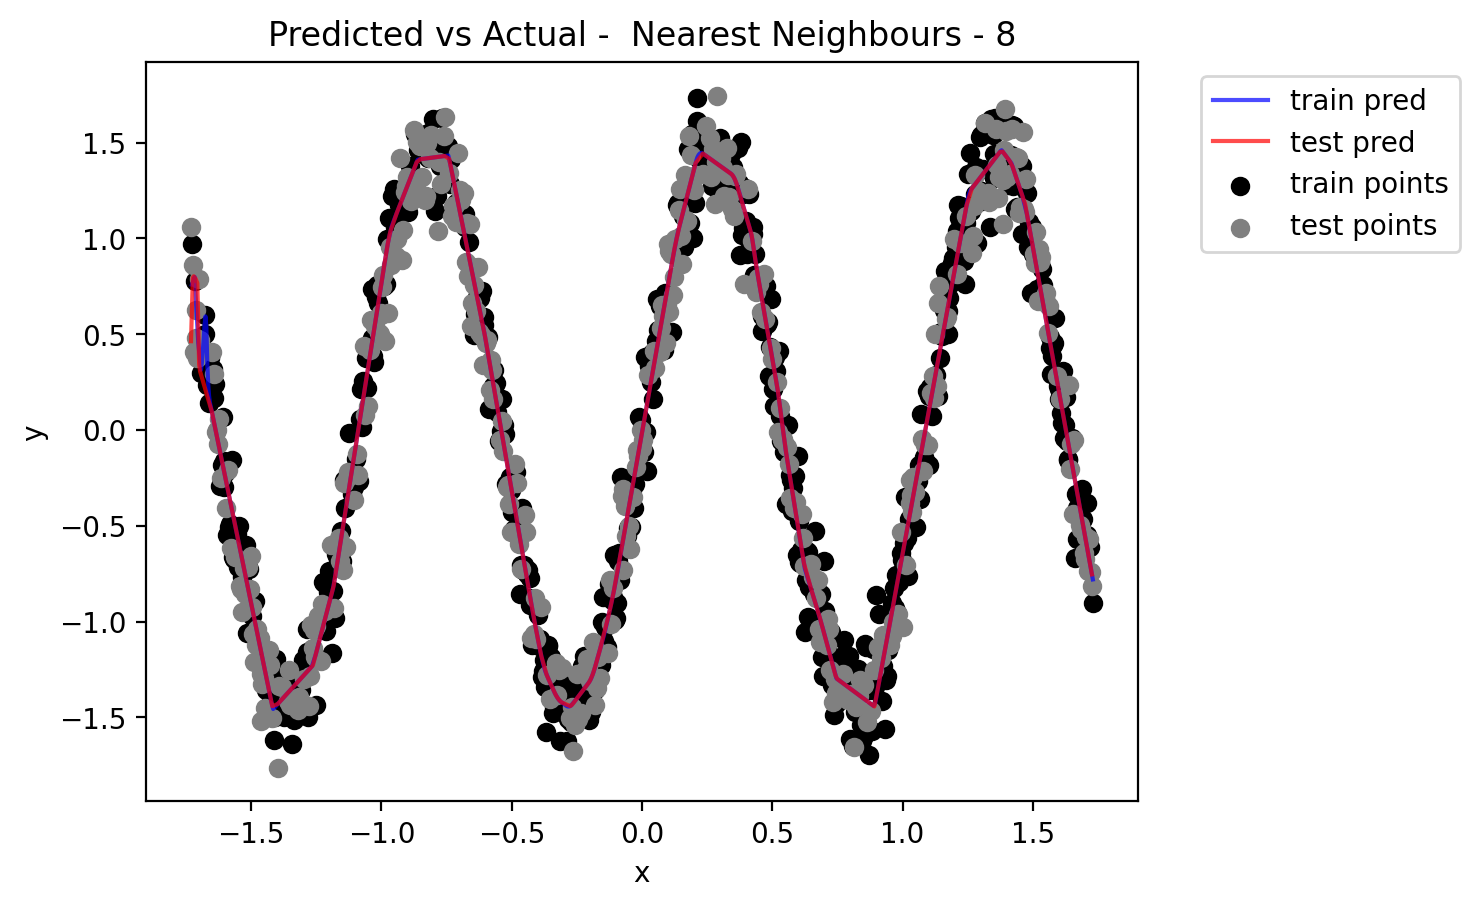

In [10]:
for k in range(2,9):
    data = graph_and_data(k,x,y)
    print(data)
    model = model_train(k, data)
    results_show(model,data)